In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sklearn
import matplotlib.pyplot as plt
import scipy

import math

# Programmation de la méthode SCMK

In [3]:
def fun1(P,L,F,Q,beta,gamma):
    
    fct = beta * np.trace(P.T @ L @ P) + gamma * np.linalg.norm(F - P @ Q,ord='fro')**2
    
    grad = 2 * beta * L @ P + gamma * (-2 * F @ Q.T + 2 * P @ Q @ Q.T)
    return fct,grad

def fun2(P,args):
    
    fct = args[3] * np.trace(P.T @ args[0] @ P) + args[4] * np.linalg.norm(args[1] - P @ args[2],ord='fro')**2
    
    grad = 2 * args[3] * args[0] @ P + args[4] * (-2 * args[1] @ args[2].T)
    return fct,grad

In [4]:
def fun_objectif(K,Z,F,P,Q,alpha,beta,gamma,L):
    res = np.trace(K -2*K @ Z + Z.T @ K @ Z) + alpha * np.linalg.norm(Z,ord=1)+ beta * np.trace(P.T @ L @ P) + gamma * np.linalg.norm(F - P @ Q,ord='fro')**2
    return(res)

In [5]:
def SCMK(data,c,alpha,beta,gamma,mu,nb_etape=10,tol=1e-3):
    '''data : tensor with dim(r,n,n) where data[k,:,:] is the kernel k on data'''
    ''' c : number of cluster '''
    
    ''' Verifications '''
    #if( (type(data)==int) | (type(data)==float) ) : return("Error :  only a number in input")
    #if( (len(data.shape)==3) & (data.shape[1]!=data.shape[2])) : return("Error : dimension of kernels")
    #if( (len(data.shape)==2) & (data.shape[0]!=data.shape[1])) : return("Error : dimension of kernel")
    
    ''' Initialisation des variables '''
    if(len(data.shape)==2):
        r = 1
        n,_ = data.shape
    else :
        r,n,_ = data.shape
    Z = np.random.uniform(0,1,(n,n))
    P = scipy.linalg.orth( np.random.uniform(0,1,(n,c)) )
    Q = scipy.linalg.orth( np.random.uniform(0,1,(c,c)) )
    #F = np.zeros((n,c))
    F = P @ Q
    list_argmax=np.argmax(F,axis=1)#donne liste indice du max par ligne
    for i in range(n):
        F[i,list_argmax[i]] = 1
        F[i,np.delete(range(c),list_argmax[i])] = 0
    
    Y = np.zeros((n,n)) # hésitation avec : Y=np.zeros((n,1)) vu le code matlab...
    w = np.ones(r)/(r**2) ## On veut que sum(sqrt(w))=1
    
    etape=0
    crit = math.inf # Critère d'amélioration du clustering, à voir comment le définir
    
    
    S = np.zeros((n,n))
    h = np.zeros(r)
    
    a=orthogonal_optimization(fun3,grad3)
    while( (etape<nb_etape) & (crit>tol) ):
        
        ''' Calcul de Kw '''
        Kw = np.zeros((n,n))
        
        if(r==1) :
            Kw = data
        else :
            for i in range(r):
                Kw += w[i]*data[i,:,:]

        ''' Update de S '''
        S = Z-Y/mu
        S[abs(S)<alpha/mu] = alpha/mu
        S = (abs(S)-alpha/mu) * np.sign(S)
        S = S-np.diag(np.diag(S))
        
        ''' Update de Z '''
        E = S + Y/mu
        dist_p = (P**2) @ np.ones((c,n)) - 2 * P @ P.T + np.ones((n,c)) @ (P**2).T # ||P_i,: - P_j,:||^2
        tmp1 = mu*np.eye(n) + 2*Kw
        tmp2 = beta/2 * dist_p - 2* Kw - mu * E
        Z = np.linalg.inv(tmp1) @ (-tmp2)
        Z = Z - np.diag(np.diag(Z))
        Z[Z<0] = 0
        Z = (Z+Z.T)/2
        
        ''' Update de Y '''
        Y = Y + mu * (S-Z)
        
        ''' Update de P '''
        D = np.diag(sum(Z))
        L = D - Z
        #P, _,_ = cutnorm.OptManiMulitBallGBB.opt_mani_mulit_ball_gbb(x=P,fun=fun2,args=[L,F,Q,beta,gamma]) #souci ici !! Pas orthogonal !!!!
        P = a.run(P,[L,F,Q,beta,gamma] )
        #print(P.T @ P) # OK avec la2ème méthode, c'est bien orthogonal
        #print(P)
        ''' Update de Q '''
        U,_,V = np.linalg.svd(F.T @ P)
        Q = U @ V.T
        
        ''' Update de F '''
        F = P @ Q
        list_argmax=np.argmax(F,axis=1)#donne liste indice du max par ligne
        for i in range(n):
            F[i,list_argmax[i]] = 1
            F[i,np.delete(range(c),list_argmax[i])] = 0
        if(r>1) :
            ''' Calcul de h '''
            for i in range(r):
                h[i] = np.trace( data[i,:,:] - 2*data[i,:,:]@Z + Z.T@data[i,:,:]@Z )

            ''' Update de w '''
            for i in range(r):
                w[i] = (h[i] * sum(1./h))**(-2)
        print(fun_objectif(Kw,Z,F,P,Q,alpha,beta,gamma,L))
        etape+=1
        #print('étape :',etape)
        #print(Z)
        
    return(list_argmax)

# TESTs (Brouillon)

In [6]:
tmp=np.concatenate([np.ones((3,3,3))*1,np.ones((1,3,3))*[1,2,1]])
print(tmp.shape)
print(tmp)

(4, 3, 3)
[[[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 2. 1.]
  [1. 2. 1.]
  [1. 2. 1.]]]


In [7]:
data=np.random.uniform(0,1,9).reshape(3,3)
data=data-np.diag(np.diag(data))
data=(data+data.T)/2
data

array([[0.        , 0.52921411, 0.6582498 ],
       [0.52921411, 0.        , 0.28111953],
       [0.6582498 , 0.28111953, 0.        ]])

In [8]:
data.shape

(3, 3)

In [9]:
c=2
alpha=2
beta=1
gamma=1
mu=1

## Choses à faire

Trouver comment update P :
- Le faire à la main -> Lagrangien : Pas réussi à trouver le lambda qui optimise
- Solveur -> Encore en cours de recherche, pas réussi à trouver un solveur avec constraint -> https://rdrr.io/cran/orthoDr/man/ortho_optim.html en R à explorer
- https://link.springer.com/article/10.1007%2Fs12532-010-0017-1 Article cité dans le programme R
- https://link.springer.com/article/10.1007/s10915-013-9740-x#author-information
- https://pypi.org/project/cutnorm/#wen2013

Comparaison entre SCMK et SC (à partir de différentes mesures) :
- Performances brutes.
- L'apport de F -> Essayer sans la partie F et juste faire un K-means sur P
- Voir ce que Q apporte -> F_i,j = 1 avec j = l'argmax de P_i,:
- Enlever la partie Spectral Clustering du code et le faire après (revient à faire seulement un MKL)
- 

Utilisation de mesures de clustering (certaines disponibles dans sklearn.metrics.) : https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics
- Rand Score + Adjusted Rand Score
- Normalized Mutual Information (NMI)
- Calinski and Harabasz score (# Pas de référence, y_true)
- Davies-Bouldin score (# Pas de référence, y_true)
- Fowlkes-Mallows index (FMI)

Mesure de similarité pour variables qualitatives :
- Ref : Jean-Philippe Vert 
- String-Kernel -> Quantifie la similarité entre chaînes de caractère (Peut-être intéressant pour la partie génomique)
    - Mismatch Kernel
    - Gappy Kernel
    - Motif Kernel
    - lien : https://string-kernel.readthedocs.io/en/latest/home.html
    
- A explorer : https://gist.github.com/karlnapf/6721192


In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import cluster, datasets
from sklearn.preprocessing import StandardScaler 
from matplotlib.colors import ListedColormap 
import pandas as pd
import scipy
from scipy.spatial import distance_matrix
import math

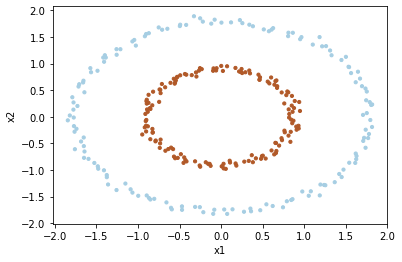

In [11]:
nsub = 150;
my2circles = datasets.make_circles(n_samples=2*nsub, factor=.5, noise=.025, shuffle=False); 
X,y=my2circles;
X = StandardScaler().fit_transform(X)
plt.scatter(X[:, 0], X[:, 1], s=10,c=y, cmap='Paired')
plt.xlabel("x1"); plt.ylabel("x2");

In [12]:
mu = [0, 0]
cov = [[0.001, 0], [0, 0.001]]  # diagonal covariance
n = 150    
x = np.random.multivariate_normal(mu, cov, n)
col= 2*np.ones(150)

In [13]:
X = np.concatenate((X, x), axis = 0)
print(X.shape)
y = np.concatenate((y,col), axis=0)
N=450

(450, 2)


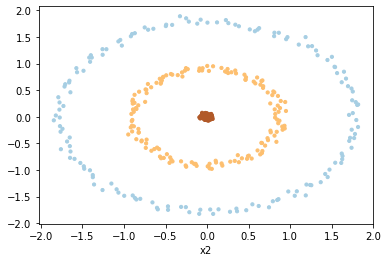

In [14]:
plt.scatter(X[:, 0], X[:, 1], s=10,c=y, cmap='Paired')
plt.xlabel("x1"); plt.xlabel("x2");

In [15]:
tmp=np.concatenate([np.ones((3,3,3))*1,np.ones((1,3,3))*[1,2,1]])

In [16]:
df = pd.DataFrame(X); 
Z=distance_matrix(df.values, df.values);

In [17]:
W1=np.zeros((N,N))
for i in range(N):
    for j in range(N):
        W1[i,j]=np.exp((-Z[i,j]**2)/(2*(0.1)**2))
W2=np.zeros((N,N))
for i in range(N):
    for j in range(N):
        W2[i,j]=np.exp((-Z[i,j]**2)/(2*(0.5)**2))

In [18]:
data=[W1-np.diag(np.diag(W1)),W2-np.diag(np.diag(W2))]

In [19]:
data=np.concatenate([[W1-np.diag(np.diag(W1)),W2-np.diag(np.diag(W2))]])
data.shape

(2, 450, 450)

246475.5353013891
56547.309713360526
25848.44537984417
15700.812492068959
11197.863568447321
8866.815889517375
7537.108374911029
6740.354025294686
6257.250283964822
5979.30586627885
5841.228006307345
5807.13940847118
5852.480818806142
5968.242053927983
6147.57206939884
6386.685825274747
6681.968985710001
7037.518354421485
7459.521796241785
7952.999359166827
8523.113180312113
9169.040416963333
9903.016992750412
10736.273088268019
11683.25537665946
12753.179601976493
13969.117366306287
15351.584715712057
16919.093845676023
18702.49352121443
20732.68607016262
23040.53721760139
25643.662387402735
28592.82311155914
31952.24769563185
35764.79178084333
40086.44012916483
44988.35102655299
50585.44868240189
56968.886689126986
64222.37921164719
72515.06979875301
81999.96982821809
92902.89456264788
105409.1216315708
119757.29457956347
136261.15409278654
155288.41638941492
177113.9203175052
202297.4982781996
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 

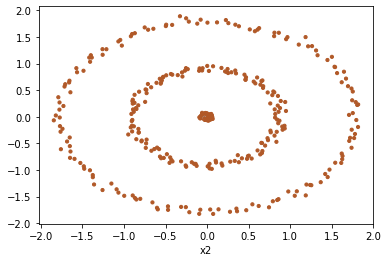

In [26]:
pred=SCMK(data,3,alpha=1e-3,beta=1e1,gamma=1e-3,mu=1e1,nb_etape=50,tol=1e-3)
print(pred)
plt.scatter(X[:, 0], X[:, 1], s=10,c=pred, cmap='Paired')
plt.xlabel("x1"); plt.xlabel("x2");

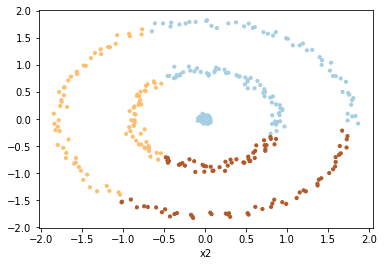

In [211]:
from sklearn.cluster import KMeans
modkmeans = KMeans(n_clusters=3, random_state=0) 
fitkmeans=modkmeans.fit(X)
y_pred=fitkmeans.predict(X)
plt.scatter(X[:, 0], X[:, 1], s=10,c=y_pred, cmap='Paired')
plt.xlabel("x1"); plt.xlabel("x2");

https://github.com/endsley/machine_learning_libs/blob/52cac5d64b55a12dfbdad1c768cdd8d79d5789f5/Optimize_Stiefel_Manifold/orthogonal_optimization.py

In [1]:
import numpy as np
#fun1(P,L,F,Q,beta,gamma)
def fun2(P,args):
    
    fct = args[3] * np.trace(P.T @ args[0] @ P) + args[4] * np.linalg.norm(args[1] - P @ args[2],ord='fro')
    return fct
def grad2(P,args):
    grad = 2 * args[3] * args[0] @ P + args[4] * (-2 * args[1] @ args[2].T + 2 * P)
    return grad


def fun3(P,args):
    
    fct =  np.trace(P.T @ args[0] @ P) + args[4]/args[3] * np.linalg.norm(args[1] - P @ args[2],ord='fro')**2
    return fct

def grad3(P,args):
    grad = 2 * args[0] @ P -2 * args[4]/args[3] * args[1] @ args[2].T
    return grad

class orthogonal_optimization:
	def __init__(self, cost_function, gradient_function):
		self.cost_function = cost_function
		self.gradient_function = gradient_function
		self.x_opt = None
		self.cost_opt = None
		self.db = {}

	def calc_A(self, x, args):
		G = self.gradient_function(x,args)
		A = G.dot(x.T) - x.dot(G.T)
		return [A,G]

	def compute_gradient(self, x, args):
		[A,G] = self.calc_A(x,args)
		return A.dot(x)

	#	Applying Sherman-Morrison-Woodbury Theorem ( A faster way to update instead of recalculating inverse )
	def constant_update_inv(self, x, G, M_inv, α_Δ):
		if α_Δ == 0: return M_inv
		d = x.shape[1]
		I = np.eye(d)

		#	1st update
		U = α_Δ*G
		V = x
		E = np.linalg.inv(I + V.T.dot(M_inv).dot(U))
		M_inv = M_inv - M_inv.dot(U).dot(E).dot(V.T).dot(M_inv)

		#	2nd update
		U = -α_Δ*x
		V = G
		E = np.linalg.inv(I + V.T.dot(M_inv).dot(U))
		M_inv = M_inv - M_inv.dot(U).dot(E).dot(V.T).dot(M_inv)
	
		return M_inv

	def run(self, x_init, args, max_rep=400):
		d = x_init.shape[0]
		self.x_opt = x_init
		I = np.eye(d)
		converged = False
		x_change = np.linalg.norm(x_init)
		m = 0

		while( (converged == False) and (m < max_rep)):
			old_α = 2
			new_α = 2
			α_Δ = 0
			cost_1 = self.cost_function(self.x_opt,args)
			[A,G] = self.calc_A(self.x_opt,args)
			M_inv = np.linalg.inv(I + new_α*A)

			while(new_α > 0.000000001):	
				if True: M_inv = self.constant_update_inv(self.x_opt, G, M_inv, α_Δ)		#	Using Woodbury inverse update
				else:	M_inv = np.linalg.inv(I + new_α*A) 									#	Using slow inverse
				next_x = M_inv.dot(I - new_α*A).dot(self.x_opt)
				cost_2 = self.cost_function(next_x,args)
				x_change = 0

				if 'run_debug_1' in self.db: print(new_α, cost_1, cost_2)
				if((cost_2 < cost_1) or (abs(cost_1 - cost_2)/abs(cost_1) < 0.0000001)):
					x_change = np.linalg.norm(next_x - self.x_opt)
					[self.x_opt,R] = np.linalg.qr(next_x)		# QR ensures orthogonality
					self.cost_opt = cost_2
					break
				else:
					old_α = new_α
					new_α = new_α*0.2
					α_Δ = new_α - old_α

			m += 1

			if 'run_debug_2' in self.db: print('Cost Norm : %.3f'%cost_2)
			if 'run_debug_3' in self.db: print('Gradient Norm : %.3f'%np.linalg.norm(self.compute_gradient(self.x_opt)))

			#print(x_change)
			if(x_change < 0.001*np.linalg.norm(self.x_opt)): converged = True

		return self.x_opt	

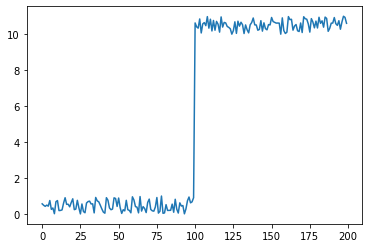

In [501]:
M=np.concatenate([np.random.uniform(0,1,(100,1)),np.random.uniform(10,11,(100,1))],axis=0)
plt.plot(M)

In [502]:
data=np.zeros((200,200))
for i in range(200):
    for j in range(200):
        data[i,j]=np.linalg.norm(M[i]-M[j],2)
data = 1 - data/np.max(data)
data = data - np.diag(np.diag(data))
data

array([[0.        , 0.9925481 , 0.98739342, ..., 0.05097462, 0.05675903,
        0.08671154],
       [0.9925481 , 0.        , 0.99484532, ..., 0.04352272, 0.04930714,
        0.07925964],
       [0.98739342, 0.99484532, 0.        , ..., 0.03836804, 0.04415246,
        0.07410496],
       ...,
       [0.05097462, 0.04352272, 0.03836804, ..., 0.        , 0.99421558,
        0.96426308],
       [0.05675903, 0.04930714, 0.04415246, ..., 0.99421558, 0.        ,
        0.9700475 ],
       [0.08671154, 0.07925964, 0.07410496, ..., 0.96426308, 0.9700475 ,
        0.        ]])

In [503]:
pred=SCMK(data,2,10**-15,1,1,1,nb_etape=100,tol=1e-3)
print(pred)

3007162928969.7617
1.58570709855257e+21
1.7757294611134486e+30
2.0432436143884846e+39
2.3901529751865303e+48
2.793035547049183e+57
3.314436788014091e+66
3.923532652147096e+75
4.738682892880412e+84
5.696607915865908e+93
6.965688529447745e+102
8.482812758785682e+111
1.0530086544651327e+121
1.3007831138977765e+130
1.6401889566544168e+139
2.057901821452253e+148
2.6558158008505538e+157
3.424507152001953e+166
4.5329968575192434e+175
5.992194653039323e+184
8.143827952393557e+193
1.099946335009165e+203
1.529909467909316e+212
2.1140703616669275e+221
3.0087575729161697e+230
4.249391166397001e+239
6.183146449814735e+248
8.939646088969388e+257
1.3323623661709002e+267
1.970659273622193e+276
2.9993164505787125e+285
4.531195906287962e+294
7.032518832292258e+303
inf
inf
inf
inf
inf


/Users/kylliann/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in matmul
  
/Users/kylliann/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:1698: RuntimeWarning: overflow encountered in reduce
  return asanyarray(a).trace(offset=offset, axis1=axis1, axis2=axis2, dtype=dtype, out=out)


inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
nan
nan
nan
nan
nan
nan


/Users/kylliann/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in matmul
  
/Users/kylliann/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in matmul
  
/Users/kylliann/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: overflow encountered in matmul
/Users/kylliann/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in matmul
/Users/kylliann/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in subtract
/Users/kylliann/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in matmul
  
/Users/kylliann/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in add
  
/Users/kylliann/opt/anaconda3/lib/python3.7/site-

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
[0 1 0 0 0 1 1 0 1 1 1 0 0 1 0 1 1 1 0 0 0 0 1 0 1 1 1 1 0 1 0 1 0 1 0 0 1
 0 0 1 1 1 1 0 1 1 1 1 0 0 1 0 0 0 0 1 0 0 0 0 1 0 1 1 1 1 1 1 1 0 1 0 1 1
 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 1 1 0 1 0 1 1 0 1 0 0 0 0 1 0 0 1 0 0 1 1 0
 0 0 1 1 0 1 0 0 0 0 1 1 1 1 0 0 1 1 1 0 0 0 0 1 0 0 1 0 1 1 1 0 1 0 1 0 0
 1 1 0 1 1 1 1 0 0 0 1 1 1 1 0 1 0 0 1 1 1 1 1 1 1 0 1 0 1 1 1 0 0 1 0 1 0
 1 1 0 1 1 0 0 1 0 1 0 1 1 1 0]
